In [1]:
import numpy as np
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'ieee'])
torch.manual_seed(1024)

k = 5 # spring constant
c = 2 # damping constant
m = 20 # load mass
# F = 0 # external force

def exact_function(t):
    d = c / (2 * m)
    w0 = np.sqrt(k / m)

    # x(t) = exp^(-d * t) * (2A * cos(phi + w * t))
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1 / (2 * np.cos(phi))
    x = (np.exp(-d * t)) * (2 * A * np.cos(phi + w * t))
    return x

# DATA PROCESSING
# generate full dataset
t_full = torch.linspace(0, 120, 1200).view(-1, 1).requires_grad_(True)
x_full = torch.tensor(exact_function(t_full.detach().numpy())).view(-1, 1).requires_grad_(True)

# boundary condition
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

# training timeline
t_train = torch.linspace(0, 10, 100).view(-1, 1).requires_grad_(True)
x_train = torch.tensor(exact_function(t_train.detach().numpy())).view(-1, 1).requires_grad_(True)

# testing timeline
t_test = torch.linspace(0, 120, 1200).view(-1, 1).requires_grad_(True)
x_test = torch.tensor(exact_function(t_test.detach().numpy())).view(-1, 1).requires_grad_(True)

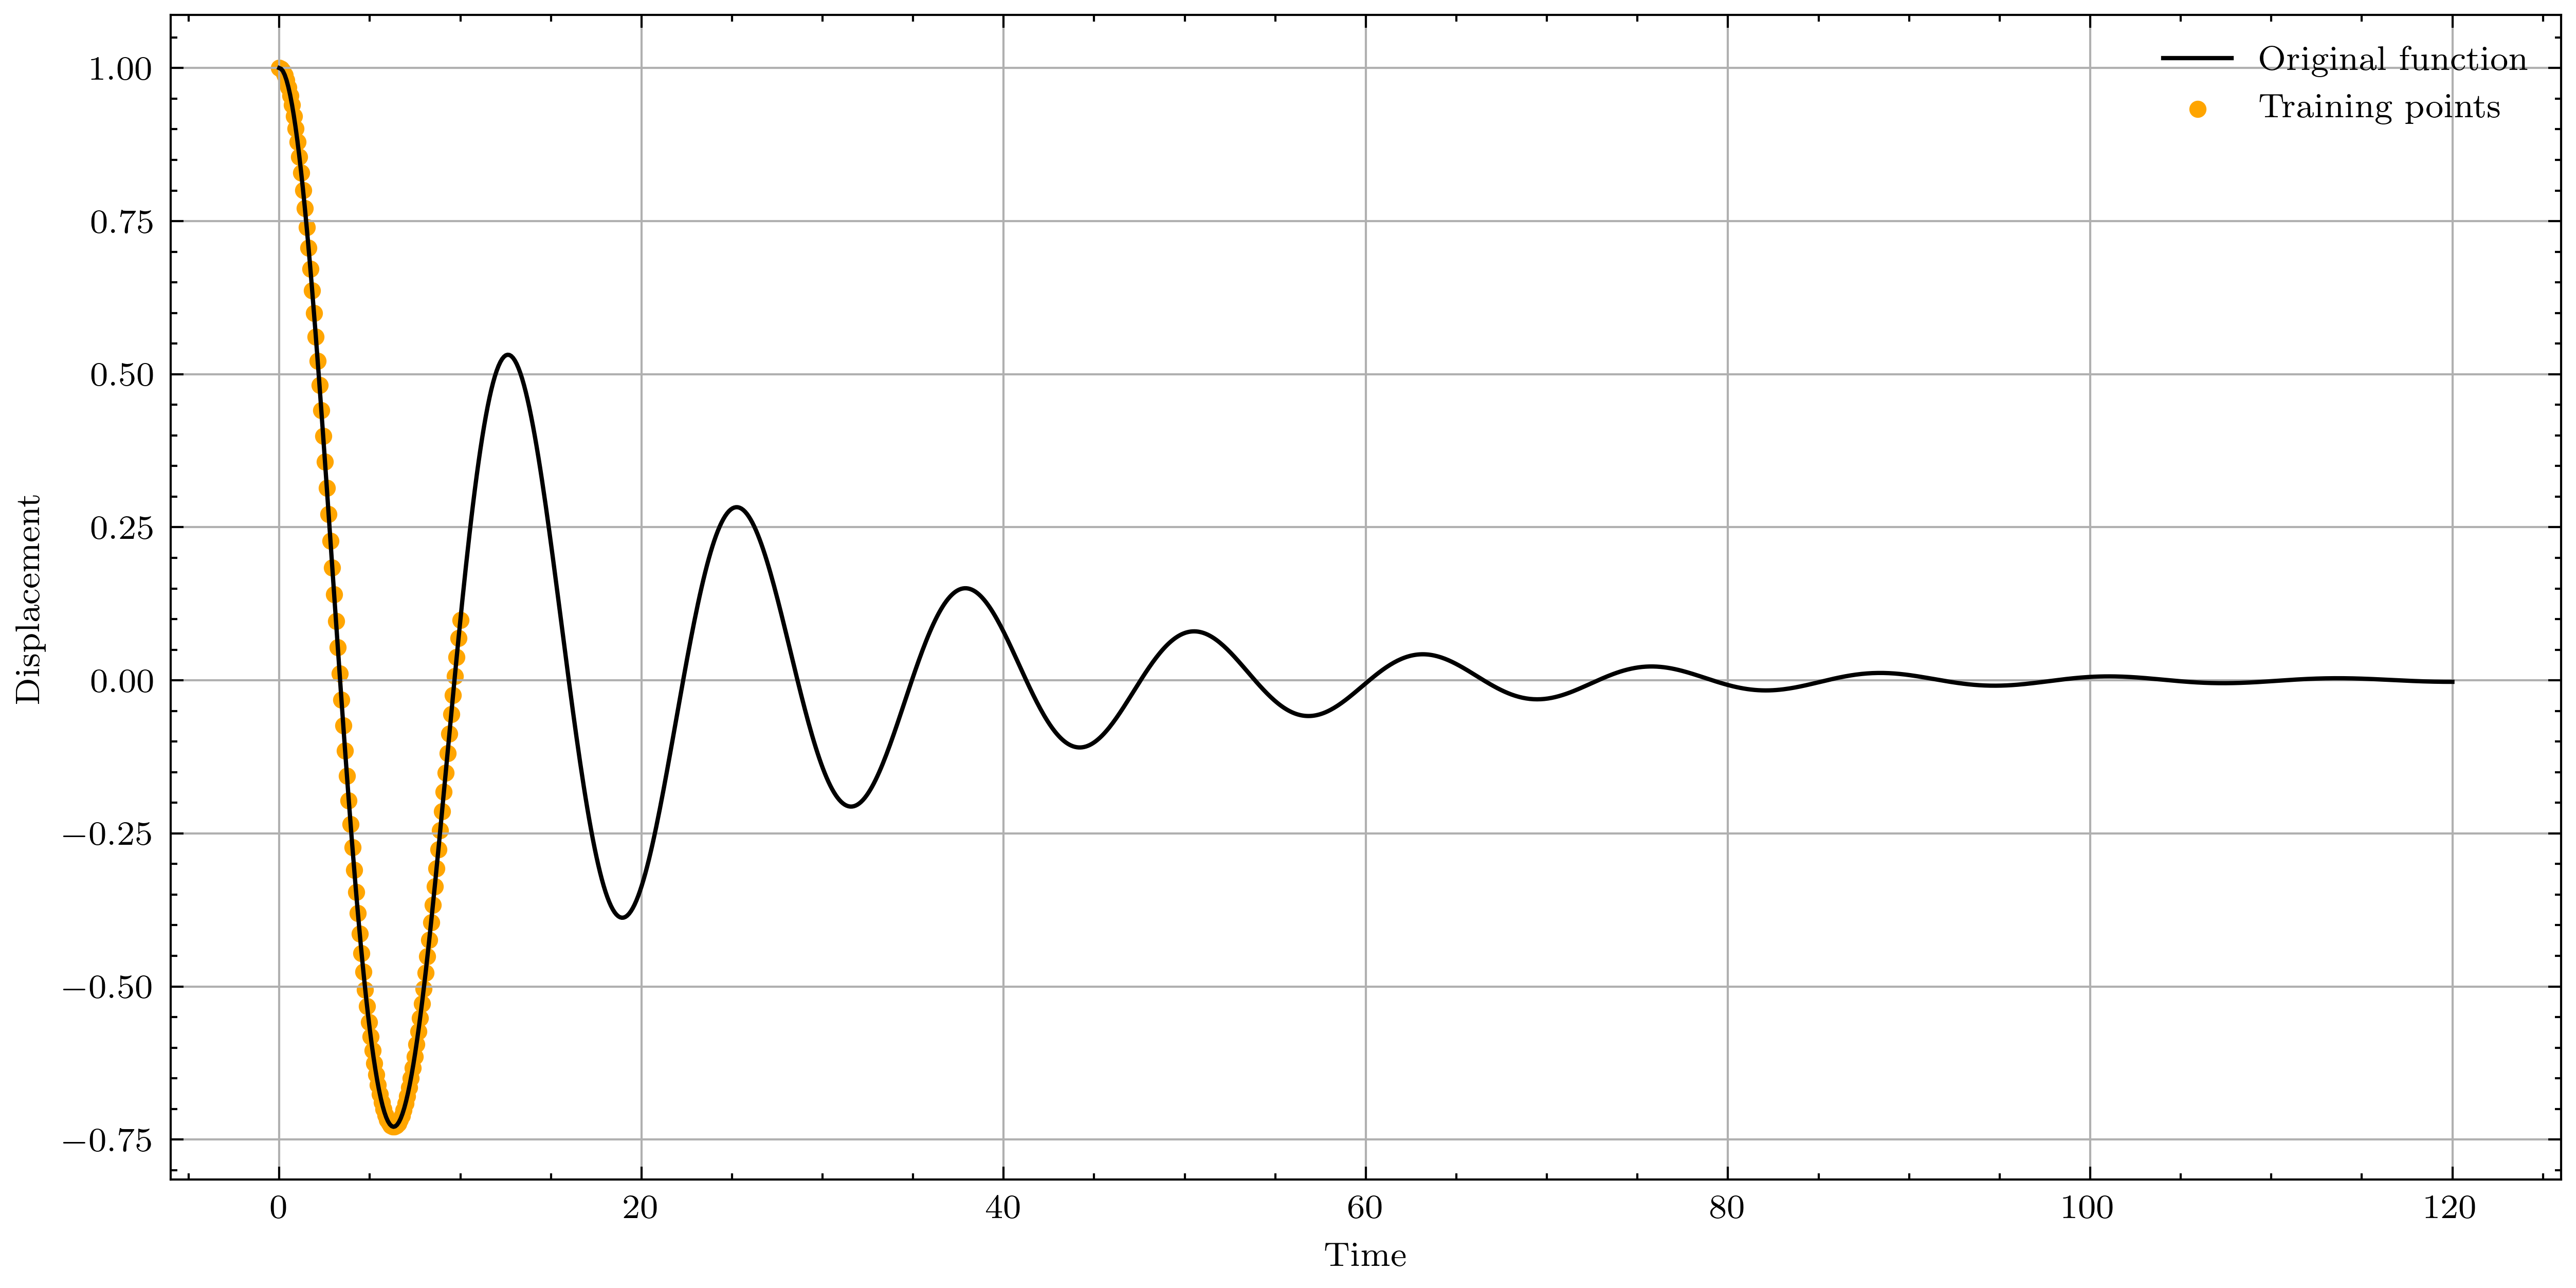

In [2]:
# Plot the original function and the predicted function
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_full.detach().numpy(), x_full.detach().numpy(), label='Original function')
# ax.plot(t_test.detach().numpy(), x_test, label='Test function')
ax.scatter(t_train.detach().numpy(), x_train.detach().numpy(), label='Training points', color='orange', marker='.')
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.grid()
plt.legend()
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class FCNN(nn.Module):
    '''
    Define neural network architecture
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN), activation()
        ])
        
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN), activation()
            ]) for _ in range(N_LAYERS)
        ])
        
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


# def loss_calc(model, criterion):
#     # general loss
#     u = model(t_train)
#     loss = criterion(u, x_train[:, 0])
    
#     return loss


In [4]:
model = FCNN(1, 1, 32, 8)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the neural network
loss_curve = {
    "epoch": [],
    "loss": [] 
}
num_epochs = 1_000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(t_train)
    loss = criterion(outputs, x_train)
    loss_curve["loss"].append(loss.item())
    loss_curve["epoch"].append(epoch)

    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    predictions = model(t_test).detach().numpy()


Epoch [100/1000], Loss: 0.0386
Epoch [200/1000], Loss: 0.0085
Epoch [300/1000], Loss: 0.0012
Epoch [400/1000], Loss: 0.0012
Epoch [500/1000], Loss: 0.0007
Epoch [600/1000], Loss: 0.0001
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0002
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0002


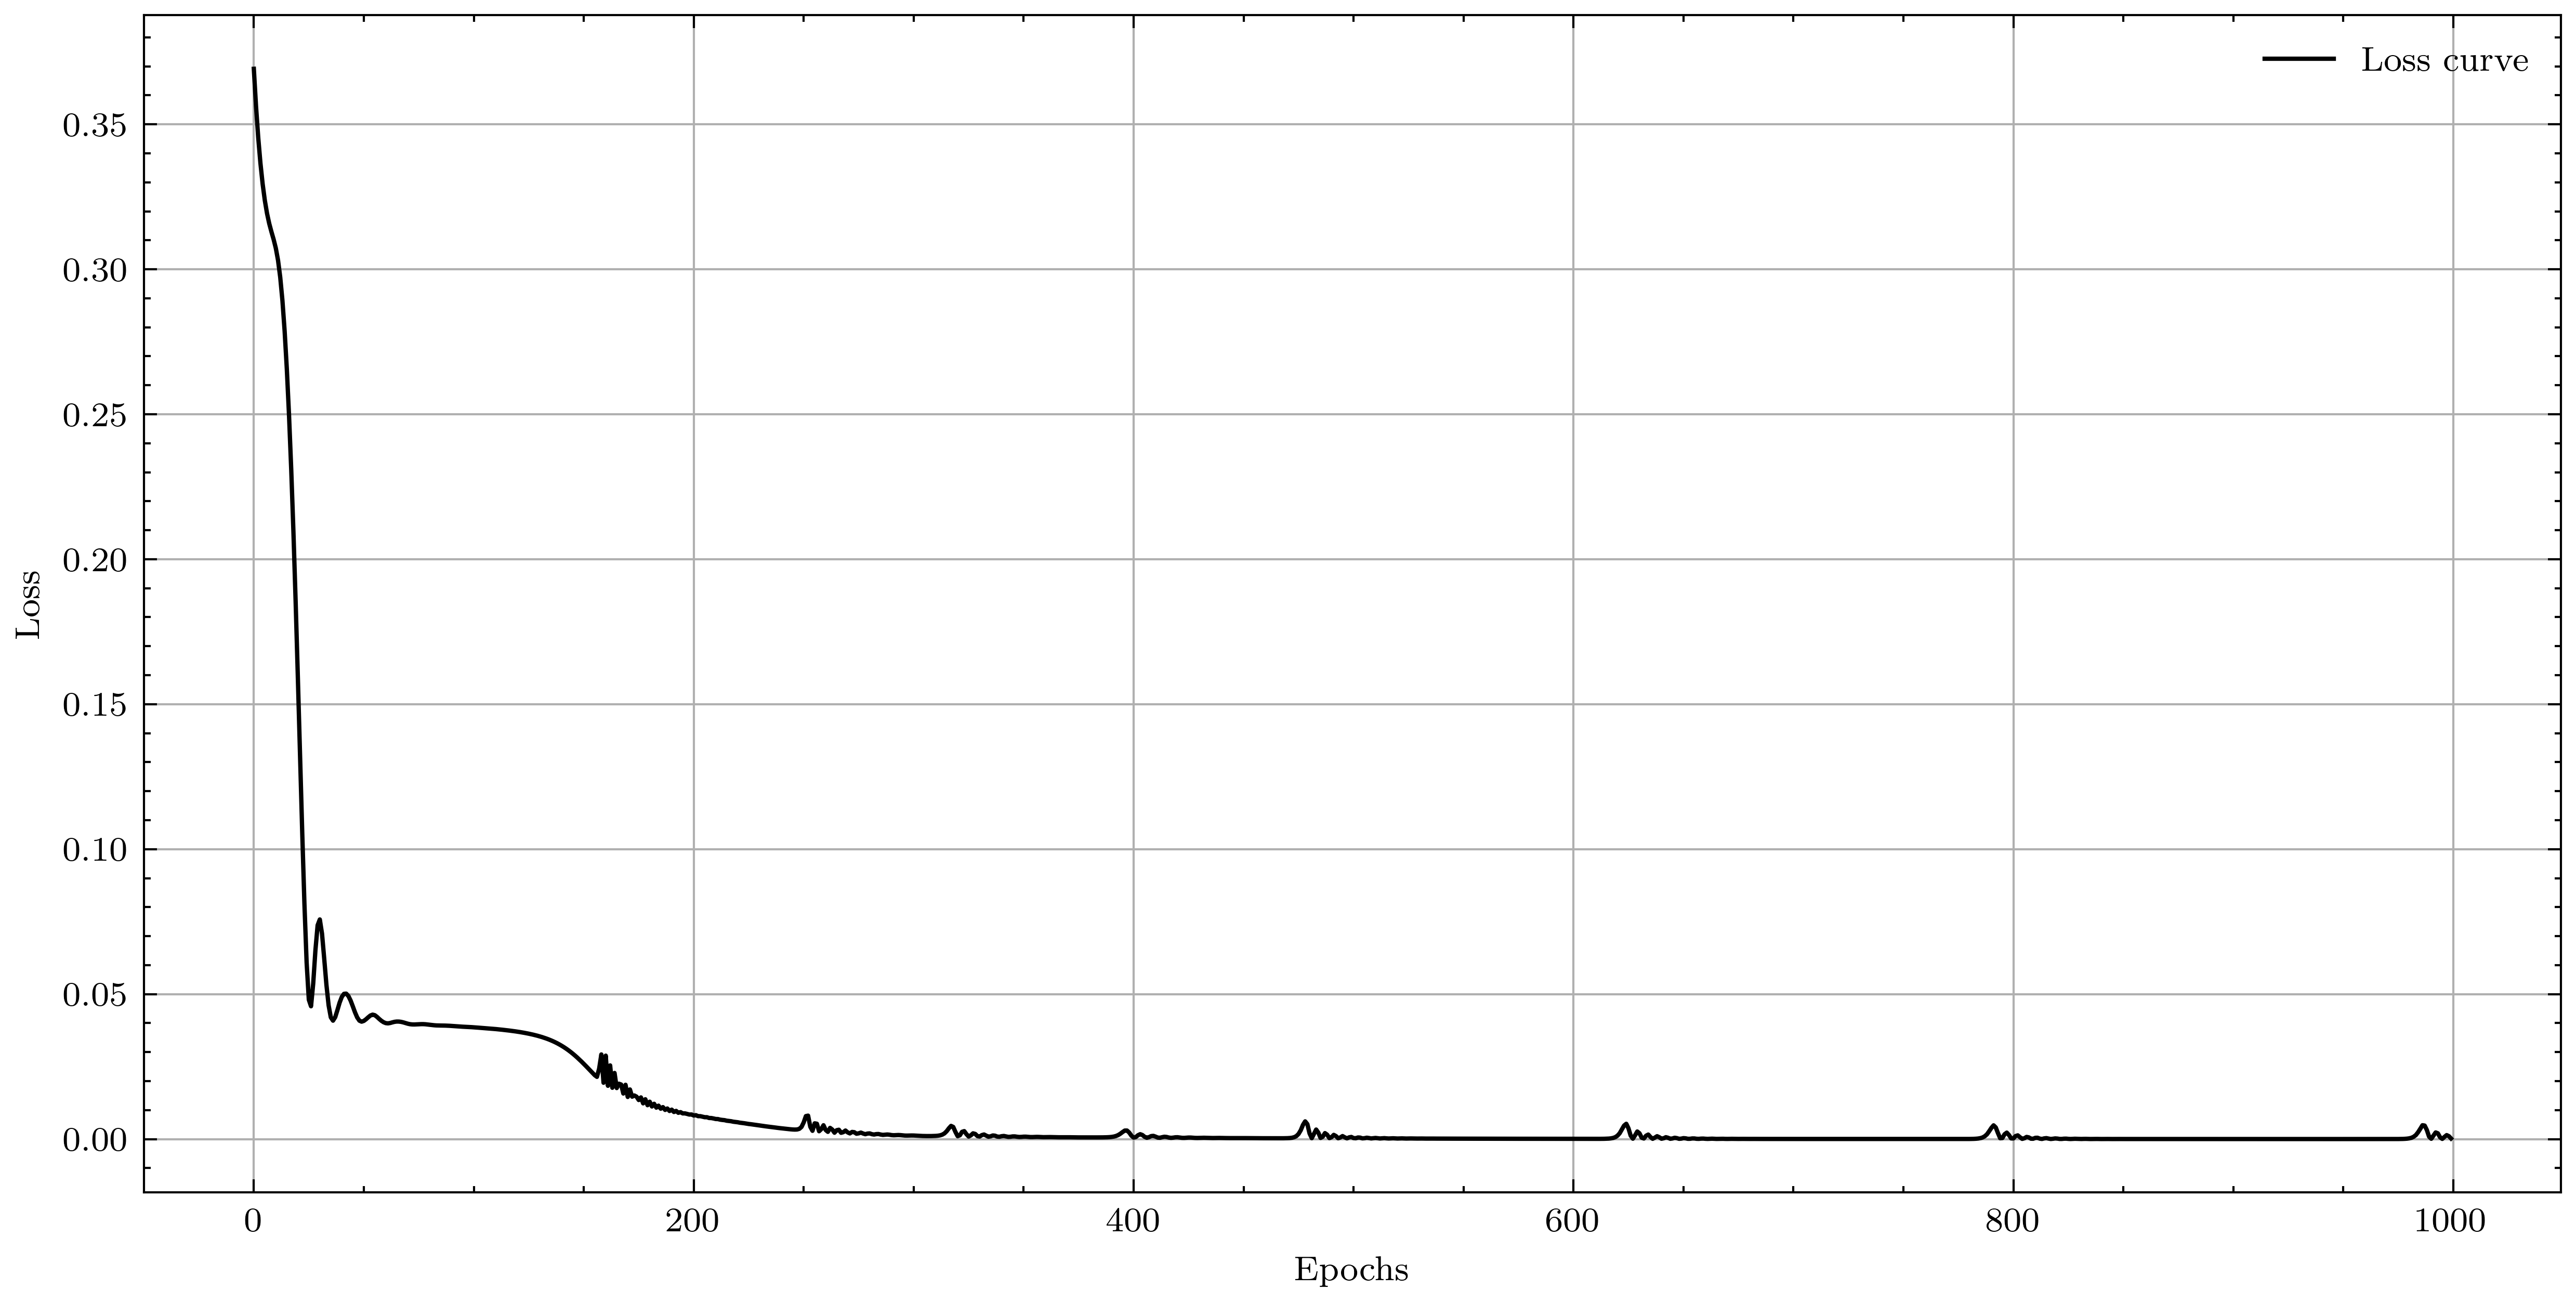

In [5]:
# Plot the original function and the predicted function
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_curve['epoch'], loss_curve['loss'], label='Loss curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

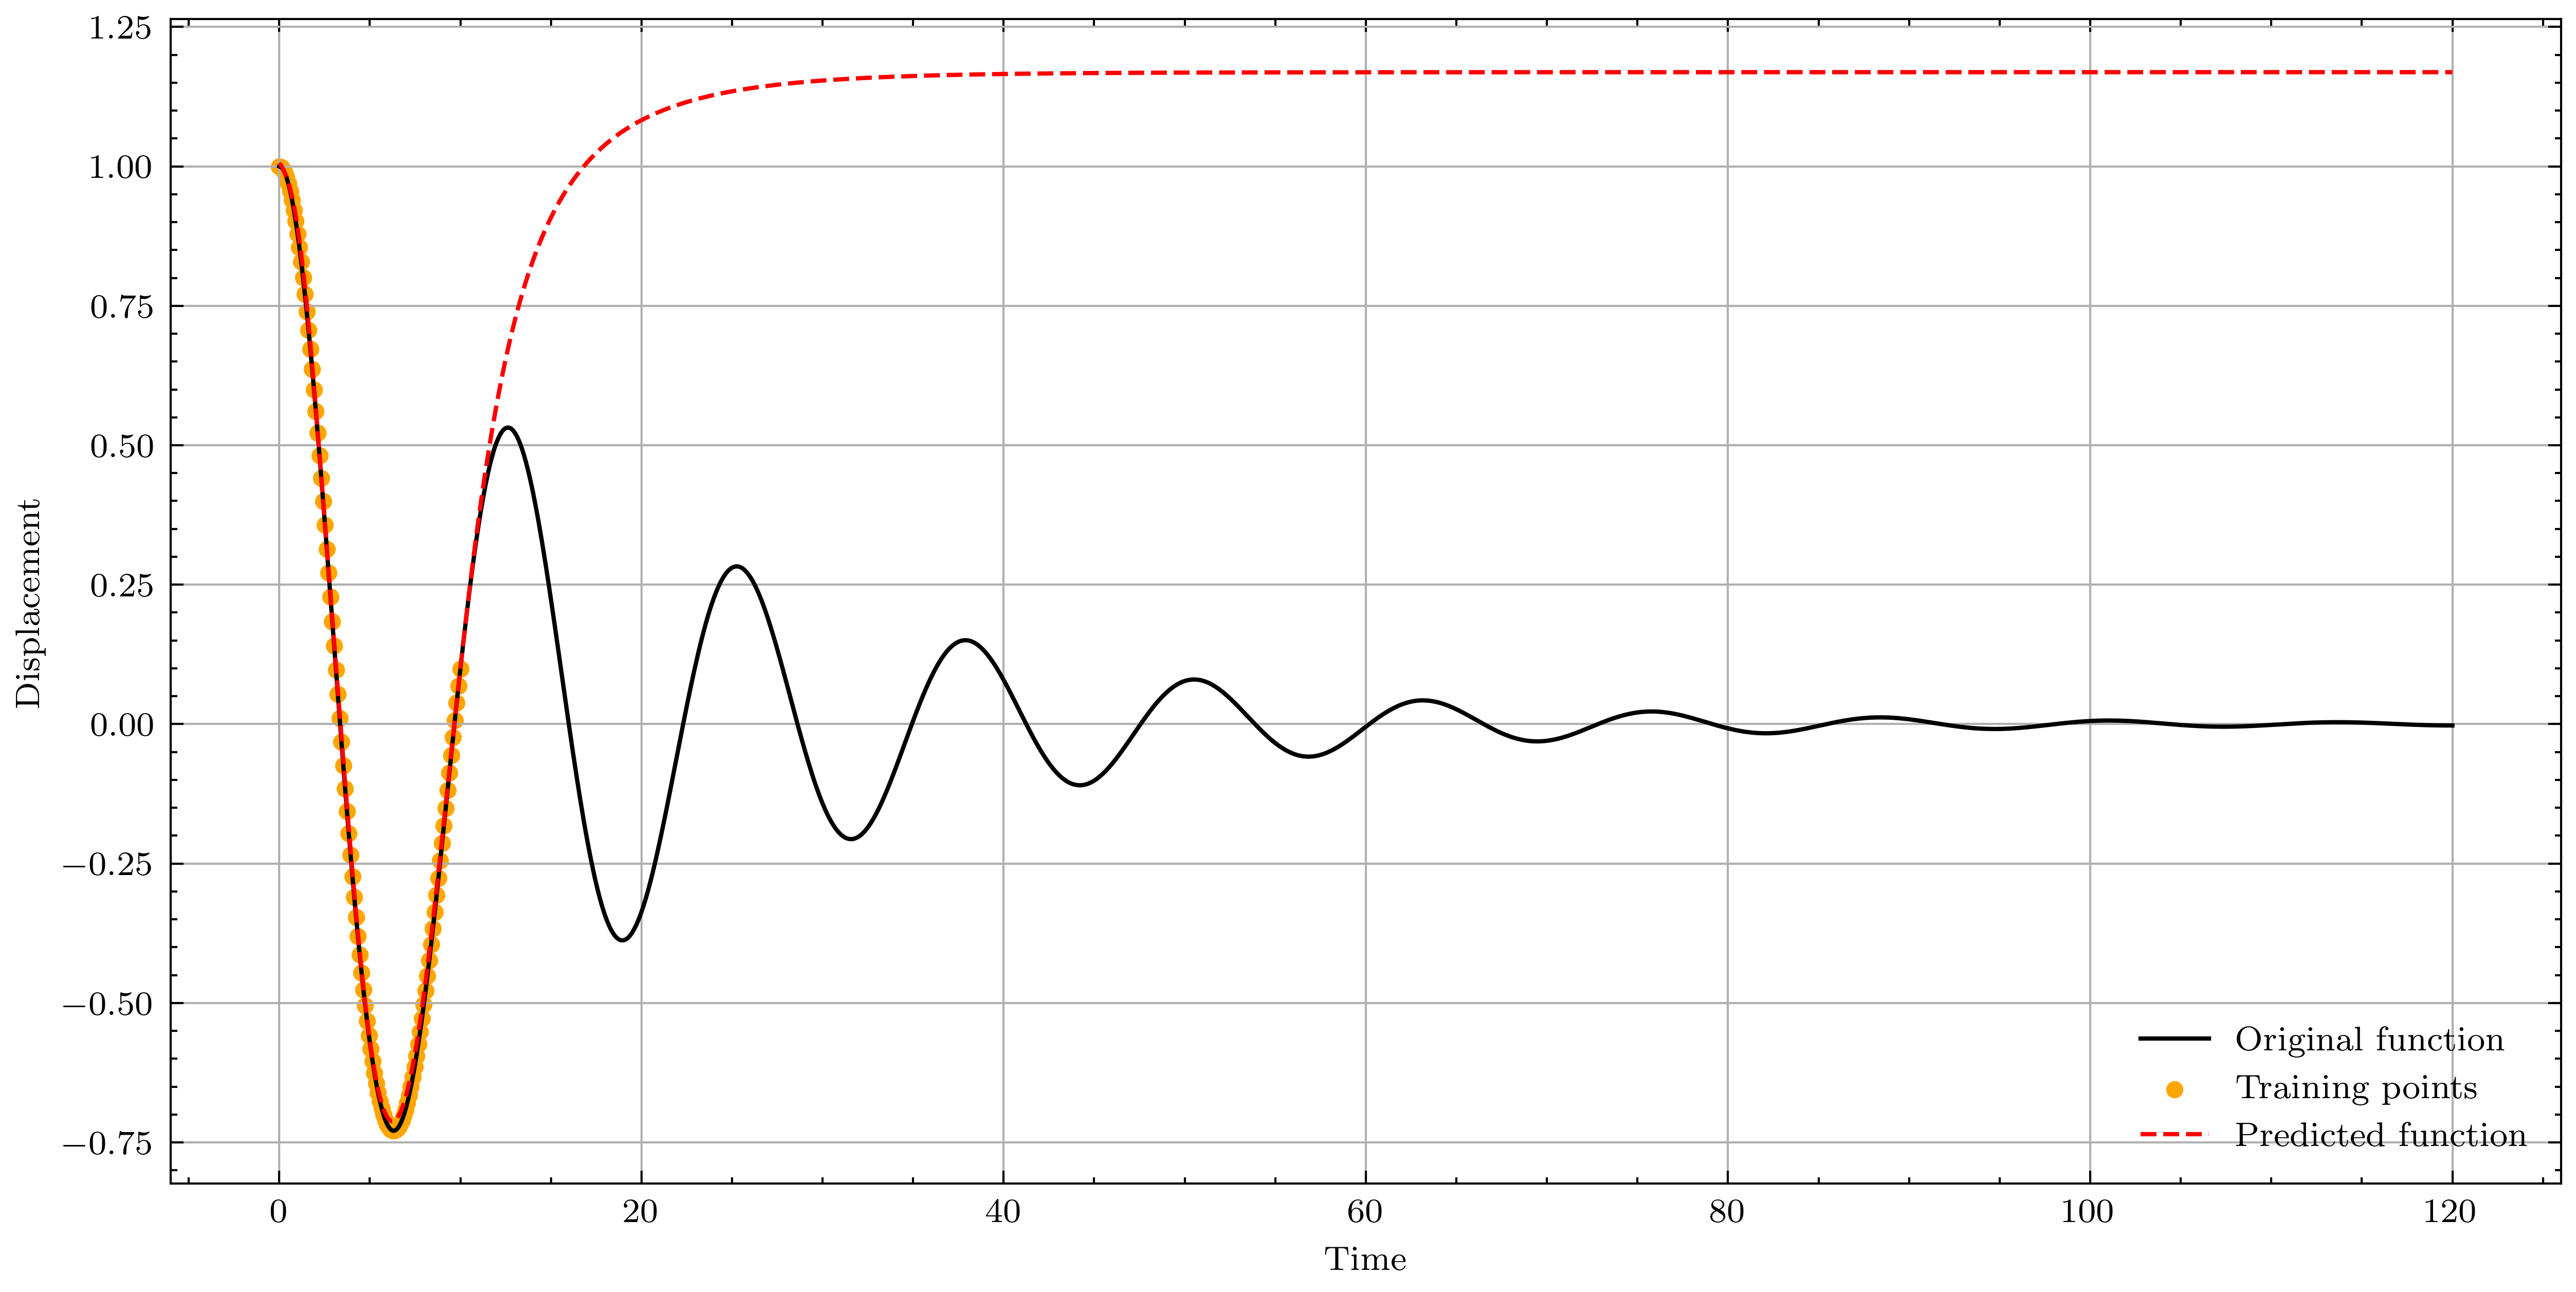

In [6]:
# Plot the original function and the predicted function
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_full.detach().numpy(), x_full.detach().numpy(), label='Original function')
ax.scatter(t_train.detach().numpy(), x_train.detach().numpy(), label='Training points', color='orange', marker='.')
ax.plot(t_test.detach().numpy(), predictions, label='Predicted function')
# ax.scatter(t_train, x_train, color='orange', label='Training samples')
# ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.grid()
plt.legend()
plt.show()